# Portfolio Management using the Efficient Frontier


In this project, we will conduct a top-down analysis; however, macroeconomic factors such as the inflation rate will be omitted for convenience. Hence, we will proceed through the following pipeline:

1. Perform an industry analysis based on the sector ETFs' performance over the past three years.
2. Select sectors that have the following traits for further investigation of assets within those sectors:
    - Exhibit positive risk-adjusted performance 
    - Low correlation between asset classes  
3. If investing in an individual asset rather than a sector ETF yields a better risk-adjusted return, substitute the ETF with the individual asset in the portfolio.
4. Optimize the efficient frontier to determine the optimal weights of the asset classes.


Only sector indexes will be used in portfolio management, including:

- XLE: Energy Select Sector SPDR Fund
    - EXXON MOBIL CORP (XOM)
    - CHEVRON CORP (CVX)
- XLF: Financial Select Sector SPDR Fun
    - Berkshire Hathaway Inc. Class B (BRK.B)
    - JPMorgan Chase & Co. (JPM)
- XLU: Utilities Select Sector SPDR Fund
    - Exelon Corp (EXC)
    - Xcel Energy Inc (XEL)
- XLK: Technology Select Sector SPDR Fund
    - Microsoft Corporation (MSFT)
    - Apple Inc. (AAPL)
- XLV: Health Care Select Sector SPDR Fund
    - Pfizer Inc. (PFE)
    - Thermo Fisher Scientific Inc. (TMO)
- XLY: Consumer Discretionary Select Sector SPDR Fund
    - Amazon.com Inc (AMZN)
    - Home Depot Inc (HD)
- XLP: Consumer Staples Select Sector SPDR Fund
    - COCA COLA CO (KO)
    - COSTCO WHOLESALE CORP	(COST)
- GLD: SPDR Gold Shares





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Github_Commit/MPT

/content/drive/MyDrive/Github_Commit/MPT


In [3]:
!git config --global user.email 'victorius918@gmail.com'
!git config --global user.name 'HyunminHong'

In [4]:
!git add Sector_Portfolio.ipynb

In [5]:
!git commit -m 'MPT portfolio statistics'
!git push

[master 6427391] MPT portfolio statistics
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Sector_Portfolio.ipynb (93%)
remote: Invalid username or password.
fatal: Authentication failed for 'https://github.com/HyunminHong/MPT.git/'


In [6]:
import yfinance as yf
from pandas_datareader import data as pdr
import scipy.stats
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import mpl, plt 
plt.style.use('seaborn') 
mpl.rcParams['font.family'] = 'serif' 
%matplotlib inline
yf.pdr_override()

<ipython-input-6-4e498f5b1119>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Asset Returns
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}\approx \log(1 + P_t),\quad\quad \log R_t = \log P_t - \log P_{t-1}
$$

# Sharpe ratio vs. Sortino ratio

- **Sharpe ratio** is preferred to evaluate low-volatility investment portfolios
- **Sortino ratio** is preferred to evaluate high-volatility investment portfolios

# Efficient Frontier

\begin{align}
    \mathbb{E}(R_p) = \mathbf{w}^T\mathbf{R} \\
    \text{Var}(R_p) = \mathbf{w}^T\mathbf{\Sigma} \mathbf{w}
\end{align}

In [76]:
def extract_data(ticker, column=None, asset_class='equity', observation_period=3, startDate=None, endDate=None):
    """
    Parameters
        ticker: input tickers 
            'GS5' is a 5-year treasury bond
            'GS10' is a 10-year treasury bond
        column: if a user wants to change the column names, input the desired names
        type: 
            'equity' if one wants to extract equity data
            'bond' if one wants to extract bond data
        observation_period: the number of years of the panel data
        startDate: starting date of the panel data
        endDate: ending date of the panel data
    Returns
        df: panel data pd.DataFrame object
    """
    if endDate is None:
        endDate = dt.datetime.now()
        startDate = endDate - dt.timedelta(days=365*observation_period)
    
    if asset_class == 'equity':
        df = pdr.get_data_yahoo(ticker, start=startDate, end=endDate)['Adj Close']
        if column is None:
            return df
        else:
            df.columns = column
            return df

    if asset_class == 'bond':
        return pdr.get_data_fred(ticker, start=startDate, end=endDate)

    
def asset_return(df, rtn_type='log'):
    """
    Parameters
        df: input the panel data that we want to extract the return values
        rtn_type: choose the return type between 'log' or arithmatic'. Computational feasibility wise
    Returns
        rtn: asset return data pd.DateFrame object
    """
    if rtn_type == 'arithmatic': 
        rtn = df / df.shift(1) - 1
        rtn.dropna(axis=0, how='any', inplace=True)
    elif rtn_type == 'log': 
        rtn = np.log(df) - np.log(df.shift(1))
        rtn.dropna(axis=0, how='any', inplace=True)
    else:
        raise ValueError('Return type is not valid.')
    return rtn


def asset_statistics(df, df_market, trading_period='daily'):
    """
    Parameters
        rtn: asset prices that we want to analyse
        rtn_market: market prices based on S&P 500
        trading_period: time period of the given time series data, e.g., 'daily', 'weekly', 'monthly'
    Returns
        stats: market information statistics, e.g., market beta, volatility, Sharpe ratio
    """
    if trading_period == 'daily':
        trading_num = 252
    elif trading_period == 'weekly':
        trading_num = 52
    elif trading_period == 'monthly':
        trading_num = 12
    
    rtn = asset_return(df)
    rtn_market = asset_return(df_market)

    stats = pd.DataFrame()

    # Beta computes the market beta of each asset class
    for col in rtn.columns:
        beta = np.cov(rtn[col], rtn_market)[0][1] / np.var(rtn_market)
        stats.loc[col, 'Beta'] = beta

    # MDD computation requires to know the previous peaks
    drawdown = (df - df.cummax()) / df.cummax()
    MDD = -(drawdown.min())*100

    # We use log returns instead of returns for convenience
    returns_annual = rtn.mean()*trading_num*100
    volatility_annual = rtn.std(ddof=0)*np.sqrt(trading_num)*100
    semi_std = rtn[rtn < 0].std(ddof=0)*np.sqrt(trading_num)*100

    stats['Annualized Returns(%)'] = returns_annual
    stats['Annualized Volatility(%)'] = volatility_annual
    stats['Sharpe Ratio'] = (np.subtract(returns_annual, Rf.item())/volatility_annual)
    stats['Sortino Ratio'] = (np.subtract(returns_annual, Rf.item())/semi_std) # preferred to evaluate high-volatility portfolios
    stats['Maximum Drawdown(%)'] = MDD
    stats['Skewness'] = scipy.stats.skew(rtn_sector)
    stats['Excess Kurtosis'] = scipy.stats.kurtosis(rtn_sector)
    return stats

def portfolio_statistics(weights, rtn, trading_period='daily'):
    """
    Parameters
        weights: weights of each asset, (n,) shape will be converted to the desired forms, e.g., (n,1) or (1,n)
        rtn: asset returns that we want to analyse
        trading_period: time period of the given time series data, e.g., 'daily', 'weekly', 'monthly'
    Returns
        rtn_portfolio: portfolio returns 
        std_portfolio: portfolio volatility
    """
    if trading_period == 'daily':
        trading_num = 252
    elif trading_period == 'weekly':
        trading_num = 52
    elif trading_period == 'monthly':
        trading_num = 12

    returns_annual = rtn.mean().values.reshape(-1,1)*trading_num
    volatility_annual = rtn.cov().to_numpy()*trading_num

    rtn_portfolio = (weights.reshape(1, len(weights)) @ returns_annual)[0][0] # w.T * R
    var_portfolio = (weights.reshape(1, len(weights)) @ volatility_annual @ weights.reshape(-1,1))[0][0] # w.T * Sigma * w
    std_portfolio = np.sqrt(var_portfolio)

    return rtn_portfolio, std_portfolio


def is_normal(rtn, level=0.01, method='shapiro wilk'):
    """
    Using Jarque Bera test to determine whether the given returns are normally distributed or not.
    H0: the data in vector x comes from a normal distribution with an unknown mean and variance
    H1: the data is not from such distribution

    Parameters
        rtn: asset returns that we want to analyse
        level: confidence level, alpha
    Returns
        True if the given returns are normally distributed
        False if the given returns are not normally distributed
    """
    if method == 'jarque bera':
        testStat, pVal = scipy.stats.jarque_bera(rtn)
    if method == 'shapiro wilk':
        testStat, pVal = scipy.stats.shapiro(rtn)
    return pVal > level


def varHistoric(returns, alpha=5):
    """
    VaR Historic
    """
    if isinstance(returns, pd.DataFrame):
        return returns.aggregate(varHistoric, alpha=alpha)
    elif isinstance(returns, pd.Series):
        return -np.percentile(returns, alpha)
    else:
        raise TypeError("Not allowed data type")

def varGaussian(returns, alpha=5, modified=False):
    z = scipy.stats.norm.ppf(alpha/100)

    if modified:
        s = scipy.stats.skew(returns)
        k = scipy.stats.kurtosis(returns) + 3
        z = (z + (z**2 - 1)*s/6 + (z**3 - 3*z)*(k-3)/24 - (2*z**3 - 5*z)*(s**2)/36)
        
    return -(returns.mean() + z*returns.std(ddof=0))

def cvarHistoric(returns, alpha=5):
    if isinstance(returns, pd.Series):
        is_beyond = returns <= -varHistoric(returns, alpha=alpha)
        return -returns[is_beyond].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(cvarHistoric, alpha=alpha)
    else:
        raise TypeError("Not allowed data type")

In [77]:
# Use the following sector ETFs 
tickers_sector = ['XLE', 'XLF', 'XLU', 'XLK', 'XLV', 'XLY', 'XLP', 'GLD']

# Use SPY as the market 
tickers_market = ['SPY']

# Converts DatetimeArray/Index to PeriodArray/Index.
#df.index = df.index.to_period('W') 
columns_sector = ['Gold', 'Energy', 'Financial', 'Technology', 'Staples', 'Utilities', 'Health Care', 'Discretionary']
columns_market = ['Market']

In [78]:
df_sector = extract_data(ticker=tickers_sector, column=columns_sector)
df_market = extract_data(ticker=['SPY'])

# Use 5-year U.S. Treasury yield as a proxy for the risk-free rate
Rf = (extract_data('GS5', asset_class='bond').mean()).item()

# Find the return of each asset class as it is more informativ than closing price
rtn_sector = asset_return(df_sector)
rtn_market = asset_return(df_market)

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
stats = asset_statistics(df_sector, df_market)
stats

,Beta,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,Sortino Ratio,Maximum Drawdown(%),Skewness,Excess Kurtosis
Gold,0.117315,3.355442,15.281196,0.100909,0.136768,22.002168,-0.520287,2.448213
Energy,0.879374,27.840668,34.742074,0.749156,1.162476,39.122782,0.048331,2.336394
Financial,0.964637,12.210961,22.965202,0.452752,0.679946,25.805331,-0.111921,2.684522
Technology,1.281945,18.309807,25.948092,0.635745,0.943460,33.559071,-0.170671,1.132243
Staples,0.535111,9.550789,14.242264,0.543268,0.707618,16.302366,-0.811874,4.864166
Utilities,0.543505,5.347393,18.344912,0.192640,0.284180,20.715987,-0.229514,0.855301
Health Care,0.660245,9.029456,15.824311,0.456009,0.661495,16.061064,-0.357873,2.152068
Discretionary,1.204850,7.245488,25.395315,0.213900,0.294540,39.669574,-0.370931,1.428162


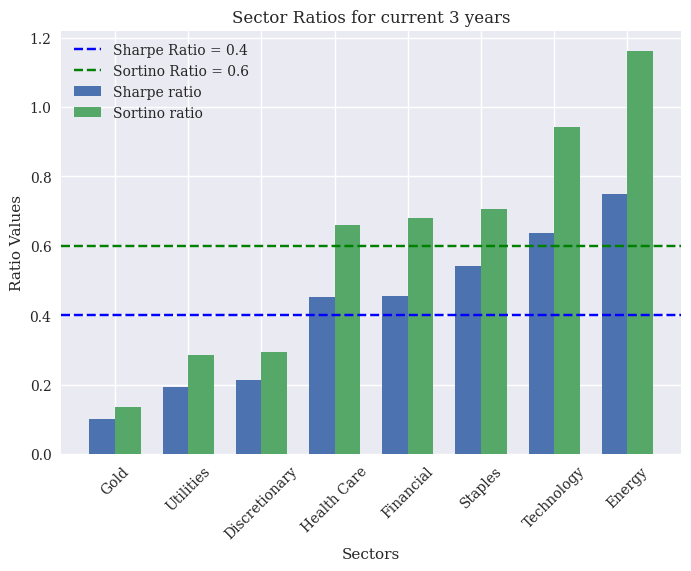

In [11]:
# Define the x-axis positions for the bars
pos = np.arange(len(stats))
bar_width = 0.35

# Plot the 'Sharpe ratio' bars in blue
plt.bar(pos, stats['Sharpe Ratio'].sort_values(), width=bar_width, label='Sharpe ratio')

# Plot the 'Sortino ratio' bars in red
plt.bar(pos + bar_width, stats['Sortino Ratio'].sort_values(), width=bar_width, label='Sortino ratio')

# Set the x-axis tick labels
plt.xticks(pos + bar_width / 2, stats['Sortino Ratio'].sort_values().index, rotation=45)

# Set the title and labels
plt.title('Sector Ratios for current {} years'.format(3))
plt.xlabel('Sectors')
plt.ylabel('Ratio Values')

# Add horizontal lines
plt.axhline(y=0.4, color='blue', linestyle='--', label='Sharpe Ratio = 0.4')
plt.axhline(y=0.6, color='green', linestyle='--', label='Sortino Ratio = 0.6')
plt.legend()

When the Sharpe ratio greater than 0.4 and Sortino ratio greater than 0.6 is considered worth to invest, only four following sectors passed the threshold:
1. Energy
2. Techonology
3. Staples
4. Health Care
5. Financial

However, it's crucial to carefully evaluate the risk-reward tradeoff, consider the investment objectives, time horizon, and risk tolerance before making a decision. Hence, we will, for now, keep other non-passed sectors to the next step. 

# Correlations between Sectors



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'Gold'),
  Text(0, 1.5, 'Energy'),
  Text(0, 2.5, 'Financial'),
  Text(0, 3.5, 'Technology'),
  Text(0, 4.5, 'Staples'),
  Text(0, 5.5, 'Utilities'),
  Text(0, 6.5, 'Health Care'),
  Text(0, 7.5, 'Discretionary')])

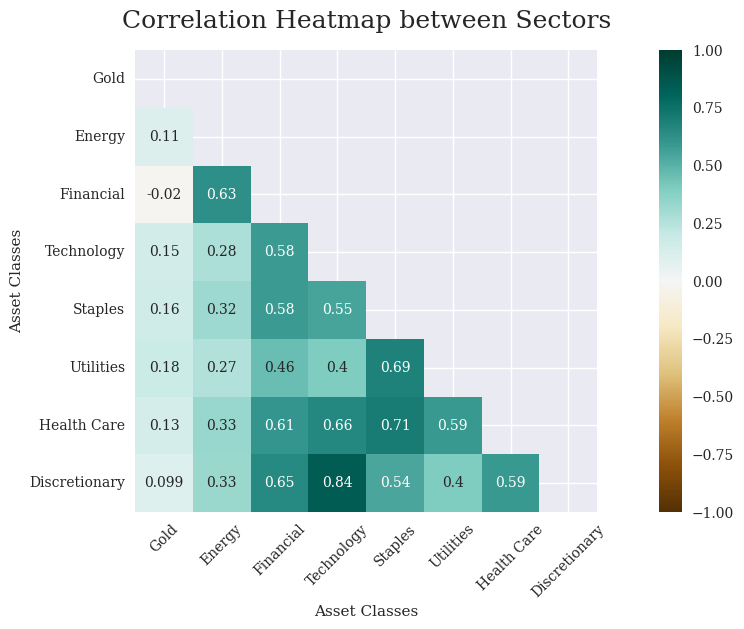

In [12]:
plt.figure(figsize=(16, 6))

# Compute the correlation matrix
corr_sector = rtn_sector.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_sector, dtype=bool))

# Create a triangular correlation heatmap
heatmap = sns.heatmap(corr_sector, mask=mask, annot=True, cmap='BrBG',
                      vmin=-1, vmax=1, square=True)

# Set the title and axis labels
heatmap.set_title('Correlation Heatmap between Sectors', fontdict={'fontsize': 18}, pad=16)
plt.xlabel('Asset Classes')
plt.ylabel('Asset Classes')

# Rotate the tick labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)

Correlation analysis measures the degree of relationship between two variables. By conducting correlation analysis, we can determine the extent of the relationship between two asset classes and assess their level of correlation. According to Modern Portfolio Theory (MPT), investors generally benefit more from diversification when there is a low correlation between two asset classes, while assets within the same asset class exhibit a high correlation.

Let us establish specific thresholds to ensure clarity before the correlation analysis.
* $0.8 \leq |\rho| \leq 1$. Very highly correlated
* $0.6 \leq |\rho| < 0.8$. Highly correlated
* $0.4 \leq |\rho| < 0.6$. Moderately correlated
* $0.2 \leq |\rho| < 0.4$. Weak correlation
* $0 \leq |\rho| < 0.2$. Very weak correlation / No correlation


According to the correlation heatmap above, **gold** and **energy** tend to show low positive correlations to other sectors, yet we observe that **energy** is highly correlated with **financial sectors**. 

**Technology** also shows low to moderate correlations, but it simultaneously exhibits a strong correlation between **discretionary**. When considering the Sharpe ratio of **discretionary** relative to **techonology**, **discretionary** is considered to not bring a high diversification benefit.

# Relative Performance by Sectors

<Axes: xlabel='Date'>

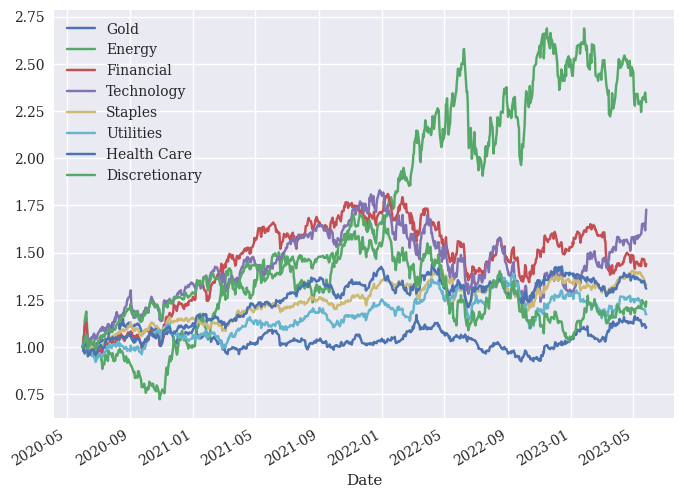

In [13]:
# Normalized prices to measure the relative performance by sectors
normPrices = df_sector / df_sector.iloc[0]
normPrices.plot(figsize=(8, 6))

In [14]:
rtn_sector.aggregate(is_normal)

Gold             False
Energy           False
Financial        False
Technology       False
Staples          False
Utilities        False
Health Care      False
Discretionary    False
dtype: bool

# VaR and CVaR

- Historical VaR
- Parametric VaR
- Modified Conish-Fisher VaR

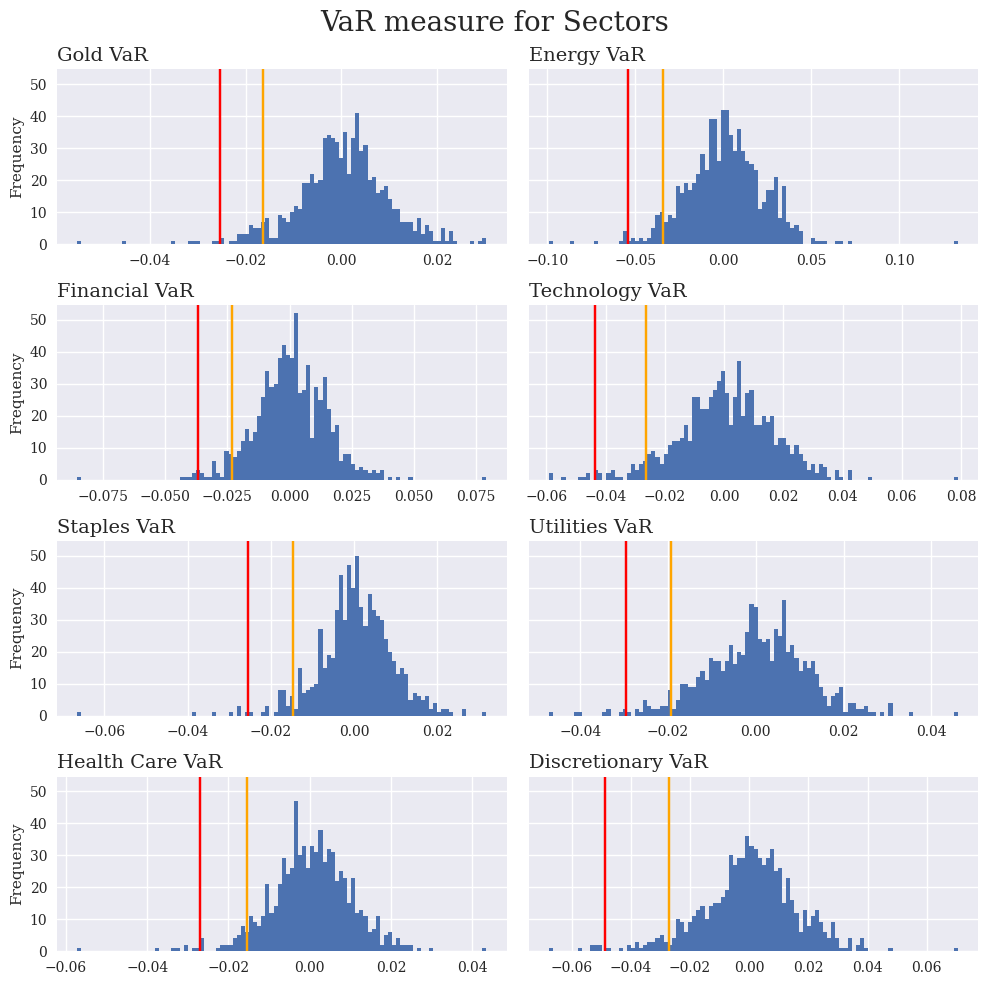

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)
fig.suptitle('VaR measure for Sectors', fontsize=20)

const = 0
for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i][j] = rtn_sector[rtn_sector.columns[const]].plot(kind='hist', bins=100, ax=axes[i][j])
        axes[i][j].axvline(np.percentile(rtn_sector[rtn_sector.columns[const]], 5), color='orange', label='5%')
        axes[i][j].axvline(np.percentile(rtn_sector[rtn_sector.columns[const]], 1), color='red', label='1%')
        axes[i][j].set_title('{} VaR '.format(rtn_sector.columns[const]), loc='left', fontsize=14)
        const += 1

plt.tight_layout() # Ensures proper spacing between subplots

<Axes: title={'center': 'VaR: Sectors'}>

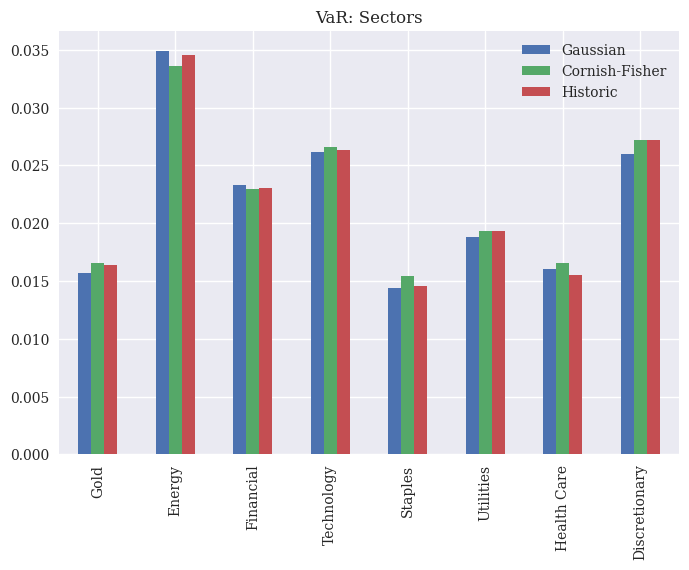

In [16]:
var_list = [varGaussian(rtn_sector), varGaussian(rtn_sector, modified=True), varHistoric(rtn_sector)]
comparision = pd.concat(var_list, axis=1)
comparision.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']
comparision.plot.bar(title="VaR: Sectors")

# Modelling

## Monte Carlo Simulation



In [35]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [99]:
# Number of different portfolios we want to simulate
simulations = 30000

# Create lists of the simulated portfolio information, e.g., returns, volatility, weights
rtn_portfolio = np.array([]) # returns
vol_portfolio = np.array([]) # volatility
wgt_portfolio = np.array([]) # weights

# Monte Carlo simulation
for s in range(simulations):
    # Generate a random weight vector
    wgt_p = np.random.random(len(rtn_sector.columns)) 
    wgt_p /= wgt_p.sum()
    
    # Generate the portfolio return & volatility of the given random weights
    rtn_p, vol_p = portfolio_statistics(weights=wgt_p, rtn=rtn_sector, trading_period='daily')
    
    # Note that Rf is in %, e.g., Rf = 1.80%. Hence, divide it by 100 
    # Find the argmax returns, volatility, weights w.r.t. Sharpe ratio
    sharpe_rat = np.subtract(rtn_p, Rf/100) / vol_p
    sharpe_max = sharpe_rat
    if sharpe_rat > m_sharpe_rat:
        m_sharpe_rat = sharpe_rat
        m_sharpe_rtn = rtn_p
        m_sharpe_vol = vol_p
        m_sharpe_wgt = wgt_p

    rtn_portfolio = np.append(rtn_portfolio, rtn_p) 
    vol_portfolio = np.append(vol_portfolio, vol_p) 
    wgt_portfolio = np.append(wgt_portfolio, wgt_p) 
    
    # Calculate the current progress
    progress = (s+1) / simulations * 100

    # Check if the current progress reaches a 10% interval
    if progress%10 == 0:
        print("Simulation progress: {}".format(progress))

# Final progress update
print("Simulation completed!")

Simulation progress: 10.0
Simulation progress: 20.0
Simulation progress: 30.0
Simulation progress: 40.0
Simulation progress: 50.0
Simulation progress: 60.0
Simulation progress: 70.0
Simulation progress: 80.0
Simulation progress: 90.0
Simulation progress: 100.0
Simulation completed!


<ipython-input-102-43e79835c1ca>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(vol_portfolio, rtn_portfolio, alpha=.8, cmap='plasma')


NameError: ignored

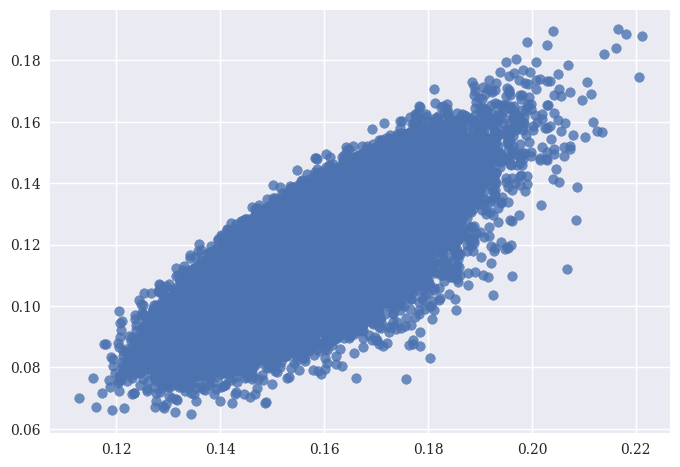

In [102]:
plt.figsize=(10,8)
plt.scatter(vol_portfolio, rtn_portfolio, alpha=.8, cmap='plasma')

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=stat['Sharpe ratio'].min(), vmax=stat['Sharpe ratio'].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),label='Sharpe Ratio',);

In [93]:
vol_portfolio.min()

0.12593892008259458

## Other optimization

In [88]:
wgt_p = np.random.random(len(rtn_sector.columns)) 
wgt_p /= wgt_p.sum()

lst = np.array([])
for i in range(10):
    lst = np.append(lst, np.array([1,2,3]))

In [89]:
lst

array([1., 2., 3., 1., 2., 3., 1., 2., 3., 1., 2., 3., 1., 2., 3., 1., 2.,
       3., 1., 2., 3., 1., 2., 3., 1., 2., 3., 1., 2., 3.])

In [60]:
rand = np.random.random(len(rtn_sector.columns)) 
rand /= rand.sum()
rtn_p, vol_p = portfolio_statistics(weights=rand, rtn=rtn_sector, trading_period='daily')

print('Portfolio return:', rtn_p)
print('Portfolio volatility:', vol_p)

Portfolio return: 0.10691736031462942
Portfolio volatility: 0.1620502178296357


In [64]:
np.subtract(rtn_p, Rf/100) / vol_p

0.5478738368231127

In [72]:
type(vol_p.item())

float

In [73]:
type(vol_p)

numpy.float64

array(5)